# Creating a model that is able to detect the type of food

### GPU required:

** Tesla T4 (Compatible with mixed percision training) **

In [1]:
import tensorflow as tf

tf.__version__

'2.18.0'

### Import helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-07-07 16:41:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-07-07 16:41:53 (25.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir, create_tensorboard_callback, make_confusion_matrix

### Use tensorflow datasets to download data

In [4]:
# Import tensorflow datasets

import tensorflow_datasets as tfds

In [5]:
datasets_lists = tfds.list_builders()
print("food101" in datasets_lists)

True


In [6]:
# Load the food 101 dataset ( Will take around 5 minutes)

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format
                                             with_info=True) # with info is required when using ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.8SLJUO_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.8SLJUO_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
# Features of food 101 dataset

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of train data

train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
for image, label in train_one_sample:
  print(f"Image Shape: {image.shape}")
  print(f"Image datatype: {image.dtype}")
  print(f"Lables {label}, Class Name: {class_names[label.numpy()]}") # Gives a different food class since we have shuffled our train dataset

Image Shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Lables 43, Class Name: fried_calamari


### Our labels are currently not one hot encoded [ 0 and 1]

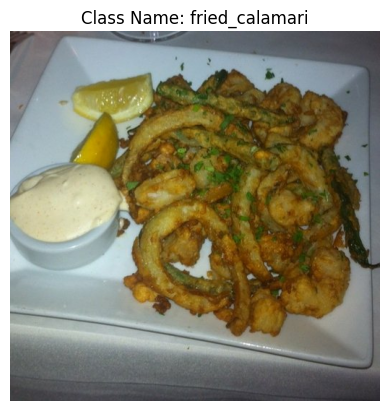

In [40]:
# Plot a RANDOM image from our datset

import matplotlib.pyplot as plt
import tensorflow as tf

plt.title(f"Class Name: {class_names[label.numpy()]}")
plt.axis("off")
plt.imshow(image)

### Create a function to pre-process images
 Turning them into batches

 Rescaling the images

 Converting the dtype from uint to float


In [14]:
def preprocess_images(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [15]:
preprocessed_images = preprocess_images(image, label)

In [16]:
preprocessed_images

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 65.81122 ,  54.811222,  50.811222],
         [ 73.331635,  62.331635,  58.331635],
         [104.015305,  89.80102 ,  86.80102 ],
         ...,
         [ 61.85712 ,  59.071384,  65.64286 ],
         [ 65.      ,  60.      ,  67.      ],
         [ 64.64282 ,  59.642822,  66.64282 ]],
 
        [[ 67.28571 ,  56.285717,  52.285717],
         [ 66.47449 ,  55.47449 ,  51.47449 ],
         [ 67.73979 ,  53.525505,  50.525505],
         ...,
         [ 64.14284 ,  61.3571  ,  67.92857 ],
         [ 65.93368 ,  60.933674,  67.93368 ],
         [ 64.285645,  59.285645,  66.285645]],
 
        [[ 58.214287,  47.214287,  43.214287],
         [ 60.867348,  46.867348,  43.867348],
         [ 71.03062 ,  55.89286 ,  52.938778],
         ...,
         [ 62.999977,  60.382614,  66.61734 ],
         [ 65.05613 ,  60.056133,  66.84185 ],
         [ 64.36218 ,  59.362183,  66.147896]],
 
        ...,
 
        [[ 64.43876 ,  65.43876 

## Turning data into batches

In [17]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
# Map the preprocessing function to training

train_data = train_data.map(map_func=preprocess_images, num_parallel_calls = tf.data.AUTOTUNE) # AUTOTUNE here tell the system to use as many processors required for execution[ Default is using only 1 chip]

# Shuffle and turn our train data into batches

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # Buffer size will shuffles 1000 elements at a time

# Map the preprocessing function to the TEST data

test_data = test_data.map(map_func=preprocess_images, num_parallel_calls = tf.data.AUTOTUNE)

# Turn test data into batches

test_data = test_data.batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)


In [19]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create a modelling callback

TensorBoard Callback : To log training results

Model Checkpoint Callback: To save our model progress after feature extraction

In [20]:
# Create tensorBoard callback

from helper_functions import create_tensorboard_callback

# Create a model checkpoint callback

checkpoint_path = "model_checkpoints/cp.weights.h5" # Use h5 only when we want to save only the weights of the model [ ie: The predictions]
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_accuracy",
                                                      save_best_only = True,
                                                      save_weights_only = True
                                                      )

## Setup the mixed precision training

In [21]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")# Mixed float 16 helps in speeding up our code

## Build feature extraction model

In [22]:
from tensorflow.keras import layers

# Create a base model

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create the input layer

inputs = layers.Input(shape=(224,224,3), name = "input_layer")

# Create global average pool

x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

# Create the output

outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x) # the elements in float32 will not be changed to float16

# Create the model

model = tf.keras.Model(inputs, outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [24]:
# Check datatype of each layer

for layer in model.layers:
  print(layer.dtype, layer.name, layer.trainable, layer.dtype_policy)

float32 input_layer True <DTypePolicy "mixed_float16">
float32 efficientnetv2-b0 False <DTypePolicy "mixed_float16">
float32 global_average_pooling_layer True <DTypePolicy "mixed_float16">
float32 dense True <DTypePolicy "mixed_float16">
float32 softmax_float32 True <DTypePolicy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.dtype, layer.name, layer.dtype_policy)

In [26]:
# Fit the model
history = model.fit(train_data, epochs = 3, validation_data = test_data,
          callbacks = [create_tensorboard_callback("food_vision_dir", "model_0"), model_checkpoint])

Saving TensorBoard log files to: food_vision_dir/model_0/20250707-165353
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 248s 91ms/step - accuracy: 0.4549 - loss: 2.3608 - val_accuracy: 0.6865 - val_loss: 1.1824
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 231s 97ms/step - accuracy: 0.6567 - loss: 1.3396 - val_accuracy: 0.7175 - val_loss: 1.0478
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 230s 96ms/step - accuracy: 0.6896 - loss: 1.1939 - val_accuracy: 0.7250 - val_loss: 1.0061


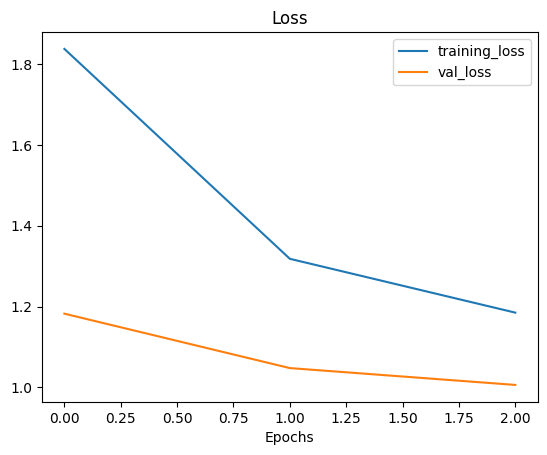

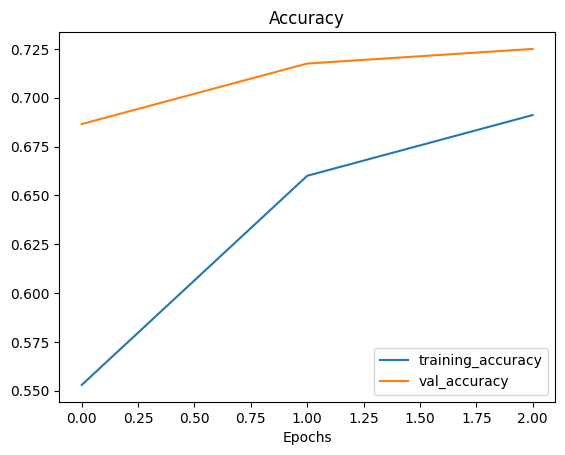

In [27]:
plot_loss_curves(history=history)

In [28]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.7265 - loss: 1.0067


[1.006140947341919, 0.7249900698661804]

## Fine Tuning the model

In [29]:
# First unfreeze all the layers in the base model

base_model.trainable = True

# Freeze the bottom 100 layers [ As in a base model the layers are ordered from bottom to top]

for layer in base_model.layers[:100]:
  layer.trainable = False

In [30]:
# Compile the fine tuned model

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4),
    metrics = ["accuracy"]
)

In [31]:
# Fit the Fine tuned model

fine_tune_history = model.fit(train_data,
                              epochs = 6,
                              validation_data = test_data,
                              initial_epoch = 3,
                              callbacks = [create_tensorboard_callback("food_vision_dir", "Fine_Tuned_Model"), model_checkpoint])

Saving TensorBoard log files to: food_vision_dir/Fine_Tuned_Model/20250707-170706
Epoch 4/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 356s 120ms/step - accuracy: 0.6571 - loss: 1.3500 - val_accuracy: 0.7987 - val_loss: 0.7156
Epoch 5/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 207s 87ms/step - accuracy: 0.8050 - loss: 0.7332 - val_accuracy: 0.8219 - val_loss: 0.6348
Epoch 6/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 309s 107ms/step - accuracy: 0.8589 - loss: 0.5272 - val_accuracy: 0.8278 - val_loss: 0.6156


### An increase in 10% accuracy when fine tuning the model

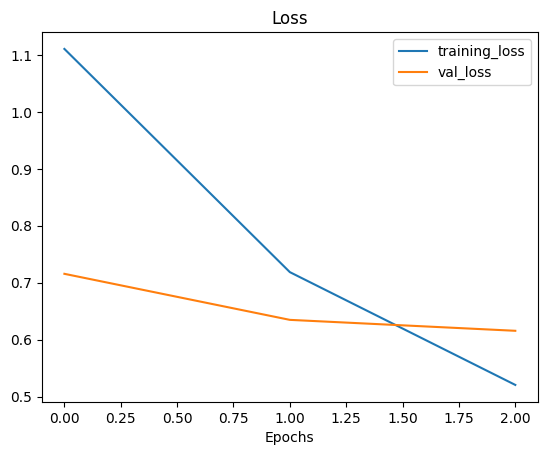

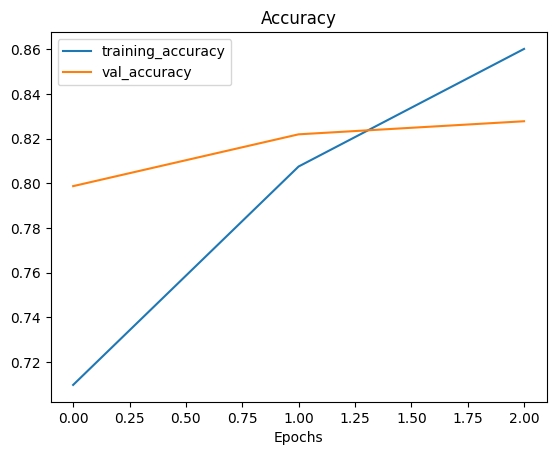

In [32]:
plot_loss_curves(fine_tune_history)

In [33]:
import pandas as pd

pd.DataFrame(fine_tune_history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.709650,1.110478,0.798693,0.715596
1,0.807485,0.718576,0.821901,0.634752
2,0.860158,0.520520,0.827762,0.615566


In [34]:
results_fine_tuned = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.8290 - loss: 0.6227


## Final Accuracy after Fine-Tuning: 82.9

In [35]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Makizushi.jpg/500px-Makizushi.jpg

--2025-07-07 17:22:31--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Makizushi.jpg/500px-Makizushi.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36209 (35K) [image/jpeg]
Saving to: ‘500px-Makizushi.jpg’

500px-Makizushi.jpg 100%[===================>]  35.36K  --.-KB/s    in 0.01s   

2025-07-07 17:22:31 (2.41 MB/s) - ‘500px-Makizushi.jpg’ saved [36209/36209]



## Make a Prediction [ In this case Sushi ]

In [36]:
# Load the image
def load_image(filename):
  raw_img = tf.io.read_file(filename)

  img_tensor = tf.image.decode_image(raw_img, channels = 3)
  img_tensor = tf.image.resize(img_tensor, [224, 224])
  img_tensor = tf.expand_dims(img_tensor, axis = 0)
  return img_tensor

In [37]:
# Make the prediction
def prediction(food_class):
  pred = model.predict(food_class)
  pred_class = tf.argmax(pred, axis = 1)
  return class_names[pred_class.numpy()[0]]

In [38]:
sushi = load_image("500px-Makizushi.jpg")
pred_class = prediction(sushi)
pred_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


'sushi'

## Visualize the prediction

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

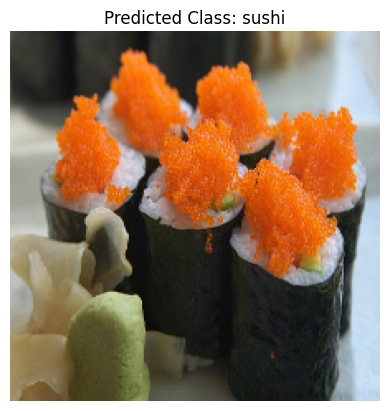

In [39]:
sushi = sushi/255.
plt.imshow(tf.squeeze(sushi, axis = 0))
plt.title(f"Predicted Class: {pred_class}")
plt.axis("off")